In [149]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from typing import Tuple, List, Optional

import os
import sys
import glob

# config 파일 경로 지정
config_dir = '../' 
# config 파일 임포트 위해 경로 추가
module_path = os.path.abspath(os.path.join(config_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import *

In [150]:
# config 파일 경로에 주의
config_path = os.path.join(config_dir, 'process_and_extract_config.yaml')
config = load_yaml(config_path)

In [151]:
def drift_correction(df, folder_list):
    time = np.arange(len(df))
    axis = folder_list[-1]
    if axis == 'T':
        p_a = np.polyfit(time, df.iloc[:, 0], 1)
        p_b = np.polyfit(time, df.iloc[:, 1], 1)
        p_c = np.polyfit(time, df.iloc[:, 2], 1)
        p_d = np.polyfit(time, df.iloc[:, 3], 1)
        p_e = np.polyfit(time, df.iloc[:, 4], 1)

        drift_trend_a = np.polyval(p_a, time)
        drift_trend_b = np.polyval(p_b, time)
        drift_trend_c = np.polyval(p_c, time)
        drift_trend_d = np.polyval(p_d, time)
        drift_trend_e = np.polyval(p_e, time)

        corrected_a = df.iloc[:, 0] - drift_trend_a
        corrected_b = df.iloc[:, 1] - drift_trend_b
        corrected_c = df.iloc[:, 2] - drift_trend_c
        corrected_d = df.iloc[:, 3] - drift_trend_d
        corrected_e = df.iloc[:, 4] - drift_trend_e

        corrected_df = pd.DataFrame({'A': corrected_a, 'B': corrected_b, 'C': corrected_c, 'D': corrected_d, 'E': corrected_e})
    else:
        p_a = np.polyfit(time, df.iloc[:, 0], 1)
        p_b = np.polyfit(time, df.iloc[:, 1], 1)

        drift_trend_a = np.polyval(p_a, time)
        drift_trend_b = np.polyval(p_b, time)

        corrected_a = df.iloc[:, 0] - drift_trend_a
        corrected_b = df.iloc[:, 1] - drift_trend_b
        
        corrected_df = pd.DataFrame({'A': corrected_a, 'B': corrected_b})
    
    return corrected_df
    

def get_data(folder_list: list, csv_file: str, columns: list) -> List[Tuple[str, pd.DataFrame]]:
    """
    데이터를 얻어오는 함수
    """
    data = []
    file_path = os.path.join(folder_list, csv_file)

    df = pd.read_csv(file_path, usecols=list(range(0, len(columns))), names=columns, header=0) 
    means = df.mean()
    df_centered = df - means
    corrected_df = drift_correction(df_centered, folder_list)
    data.append((file_path, corrected_df))
            
    return data

In [152]:
def draw_data(data: list, csv_file: str, column: str, axis: str, directory: str):
    """
    데이터를 그래프로 그리는 함수.
    data: 각 디렉토리별 파일과 데이터가 들어있는 리스트
    csv_file: CSV 파일명
    column: 데이터 열 이름
    axis: 'X', 'Y', 'Z' 축
    directory: 현재 디렉토리명
    """

    view_mapping = {
        'F': 'Front',
        'S': 'Side',
        'T': 'Top'
    }

    plt.figure(figsize=(15, 6))

    # 데이터 길이를 맞추기 위한 최소 길이
    min_len = min(len(df) for _, df in data)

    for subdir, df in data:
        subdir = os.path.basename(os.path.dirname(subdir))
        # 베어링 타입 추출 ('OR', 'H', 'IR', 'B')
        fault_type = next((x for x in ['OR', 'H', 'IR', 'B'] if x in subdir), subdir)
        df = df[:min_len].copy()

        # 중앙값 기준으로 10배가 넘는 값은 NaN으로 처리
        median_value = df[column].abs().median()
        df.loc[df[column].abs() > 10 * median_value, column] = np.nan

        # 시간 축으로 나누고, 변위 데이터는 단위 변환하여 그리기
        plt.plot(df.index / 120, df[column] * 0.0722222, label=fault_type, alpha=0.7)

        bearing_type = subdir[5:10]

    
    description = f'{bearing_type} {fault_type}, {csv_file[:1]} axis, {view_mapping[axis]} view, marker {column}'
    # 타이틀 설정
    plt.title(description, size=15)
    plt.xlabel('Time [s]', size=15)
    plt.ylabel('Displacement [mm]', size=15)
    plt.legend()

    # 그래프 보여주기
    plt.show()
    plt.close()

In [153]:
def draw_graphs(dir_list):
    '''
    dir_list에 포함되는 디렉토리들을 순회하며 그래프를 그리는 함수
    '''
    for directory in sorted(dir_list):    
        axis = directory[-1]
        csv_file_list = config.axis_to_csv_dic[axis]
        for csv_file in csv_file_list:
            data = get_data(directory, csv_file, config.axis_to_marker_dic[axis])
            for column in config.axis_to_marker_dic[axis]:
                draw_data(data=data, csv_file=csv_file, column=column, axis=axis, directory=directory)

In [154]:
def check_param(target_view: str = None, target_fault_type: str = None):
    '''
    target_view, target_fault_type가 제대로 된 값이 들어왔는지 확인하는 함수
    '''
    valid_views = config.axis_list
    valid_fault_type = config.fault_type_list

    if target_view and target_view not in valid_views:
        raise ValueError(f'target_view must be one of the {valid_views}. You entered {target_view}')
    if target_fault_type and target_fault_type not in valid_fault_type:
        raise ValueError(f'target_fault_type must be one of the {valid_fault_type}. You entered {target_fault_type}')


def get_dir_list(target_dir: str, target_view: Optional[str] = None, target_fault_type: Optional[str] = None):
    '''
    주어진 조건에 맞는 디렉토리 리스트를 반환하는 함수
    
    Parameters
    ----------
    target_dir: str
        검색할 상위 디렉토리 경로.
    target_view: str, optional
        디렉토리 이름에 포함될 뷰 정보. 'F', 'S', 'T'를 입력할 수 있으며,
        각각은 Front view, Side view, Top view를 나타낸다. 기본값은 None.
    target_fault_type: str, optional
        디렉토리 이름에 포함될 결함 유형 정보. 'H', 'B', 'IR', 'OR'을 입력할 수 있다. 기본값은 None.

    Returns
    ----------
    dir_list: List[str]  
        조건에 맞는 디렉토리 경로 리스트.

    동작 설명
    ----------
        - target_view와 target_fault_type이 모두 None이면, target_dir 안의 모든 디렉토리를 반환.
        - target_view만 None이 아니면, 디렉토리 이름에 target_view가 포함된 디렉토리만 반환.
        - target_fault_type만 None이 아니면, 디렉토리 이름에 target_fault_type이 포함된 디렉토리만 반환.
        - target_view와 target_fault_type이 모두 주어지면, 두 값이 모두 포함된 디렉토리만 반환.
    '''
    pattern = os.path.join(target_dir, '*')

    # 정상적인 값이 들어왔는지 체크
    check_param(target_view, target_fault_type)

    if target_fault_type:
        pattern += f'{target_fault_type}*'
    if target_view:
        pattern += f'{target_view}'

    dir_list = glob.glob(pattern)

    if not dir_list:
        print('The directory that meets your criteria does not exist. No graph will be generated.')

    return dir_list


In [155]:
#####################################
# 그래프 보고자 하는 타겟 디렉토리 설정     
target_dir = './0814'
######################################

dir_list = get_dir_list(target_dir, target_fault_type='IR')

draw_graphs(dir_list)


The directory that meets your criteria does not exist. No graph will be generated.


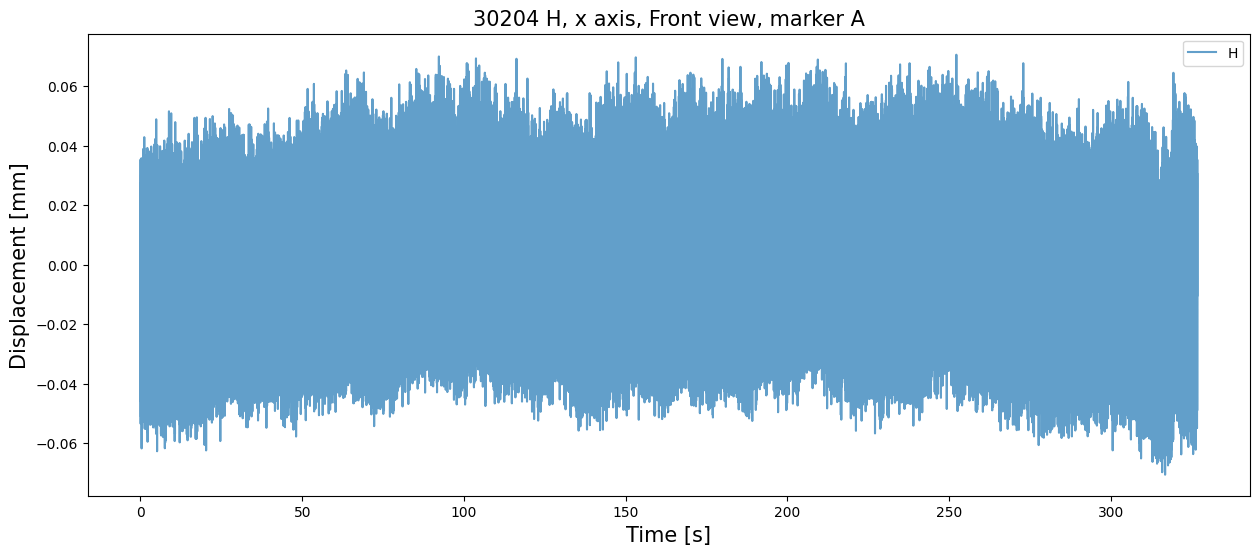

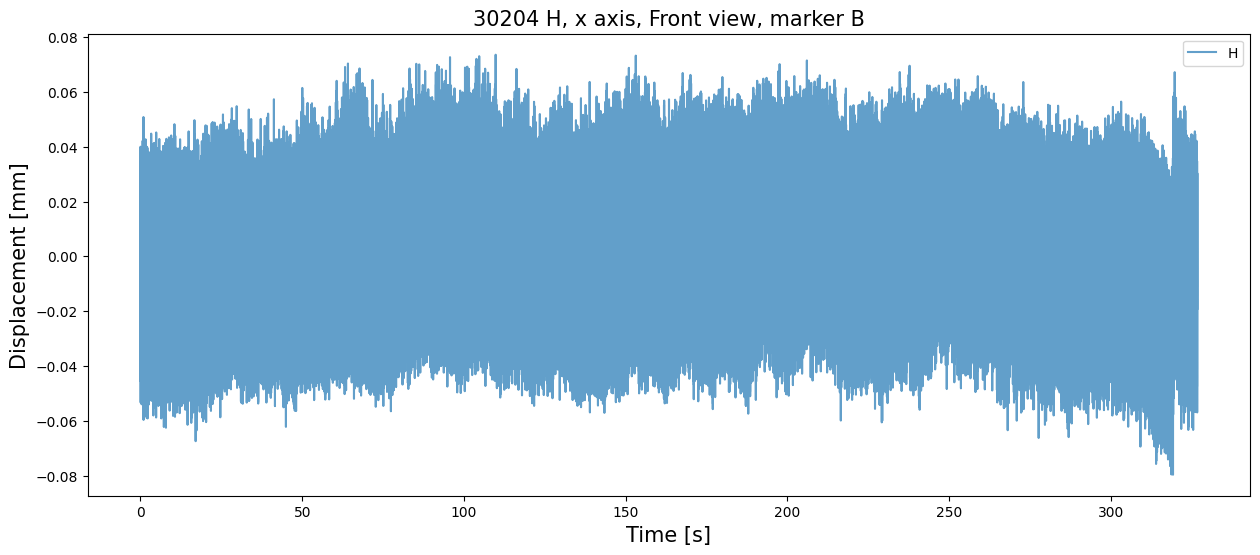

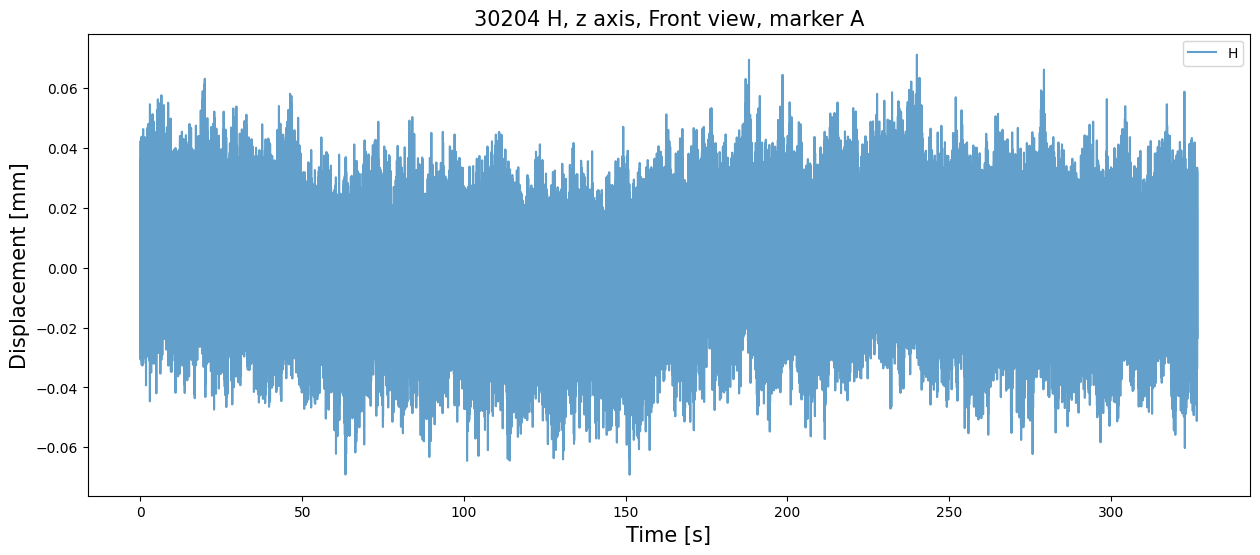

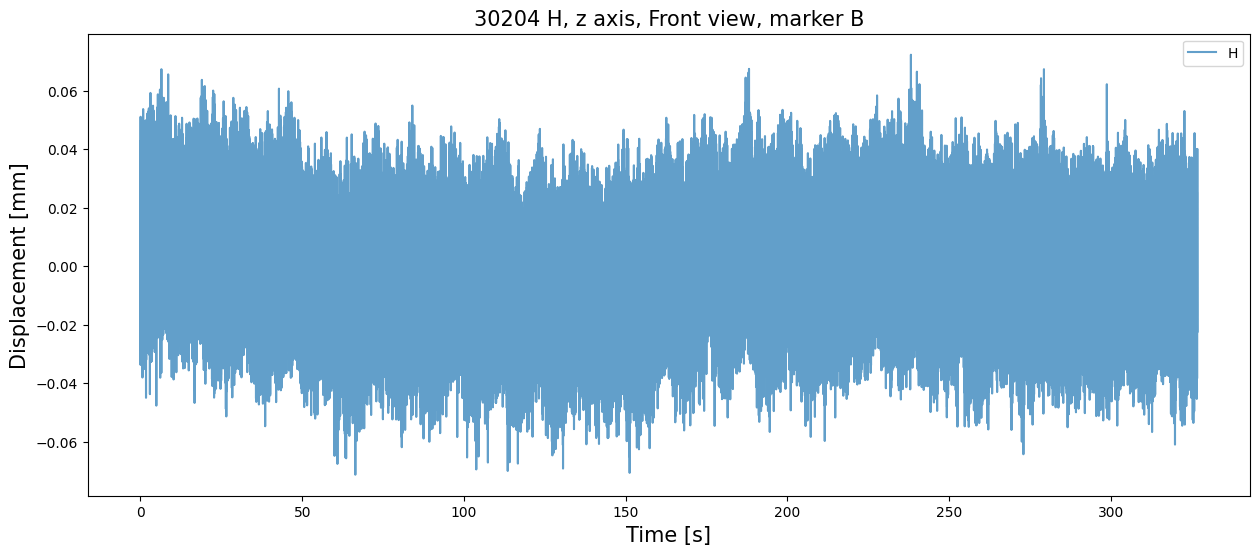

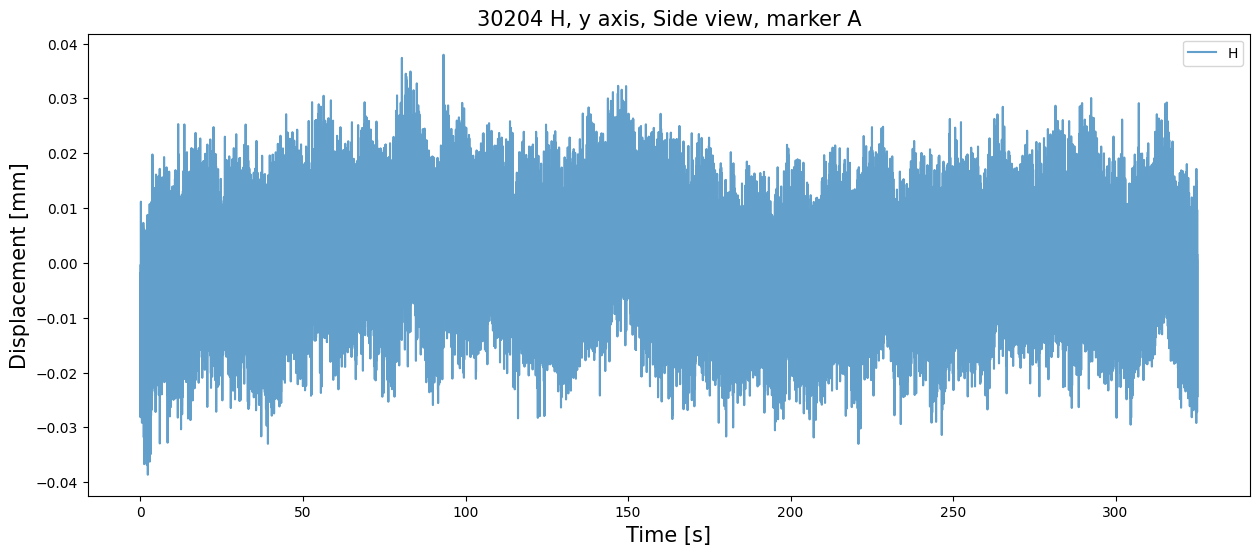

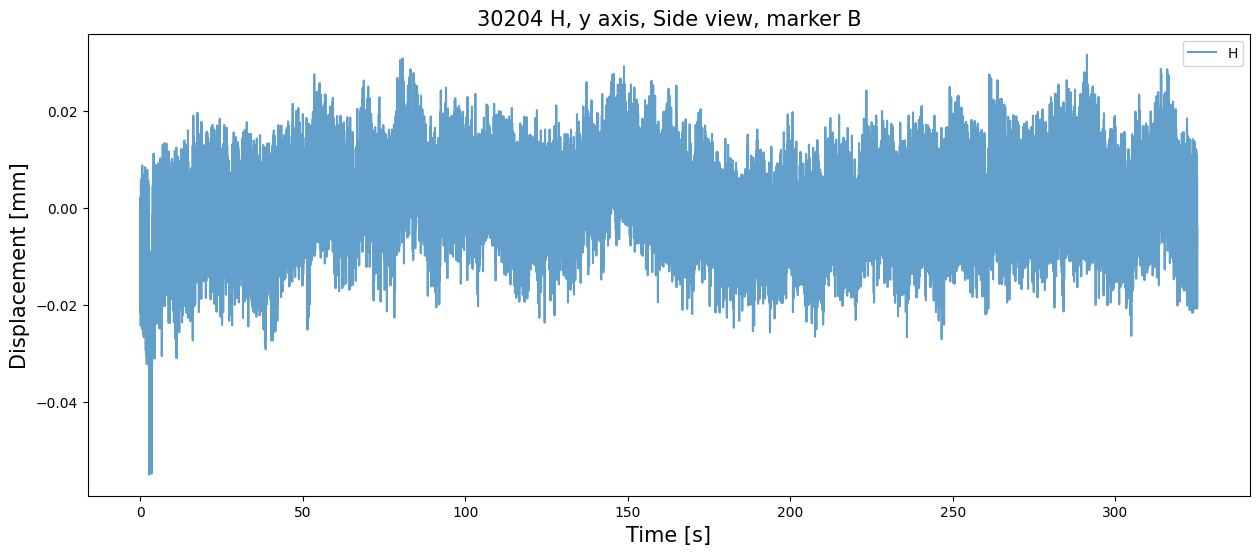

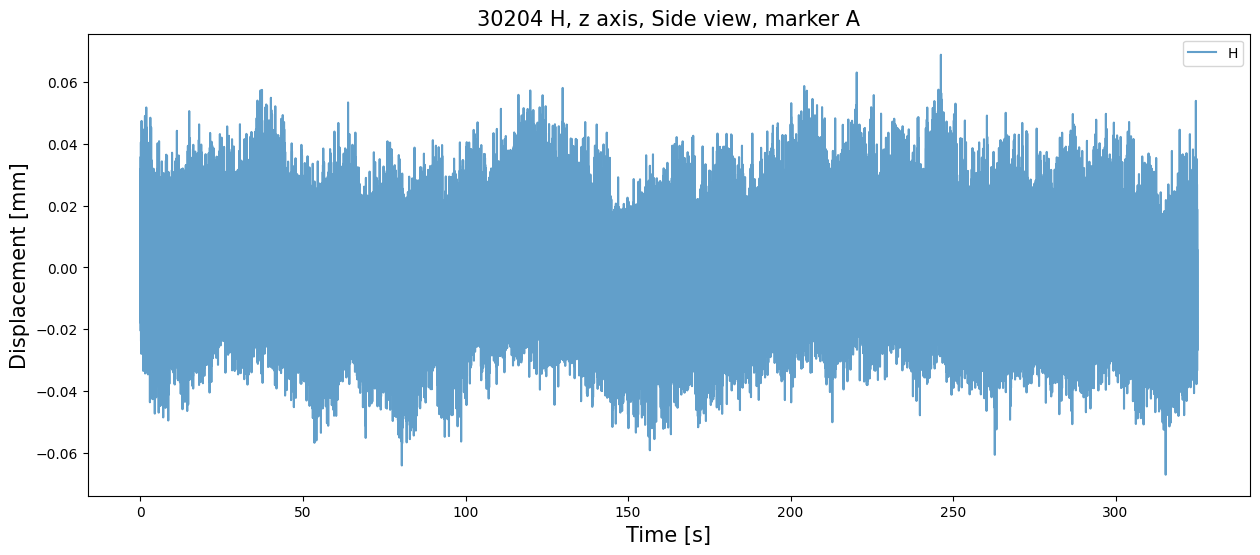

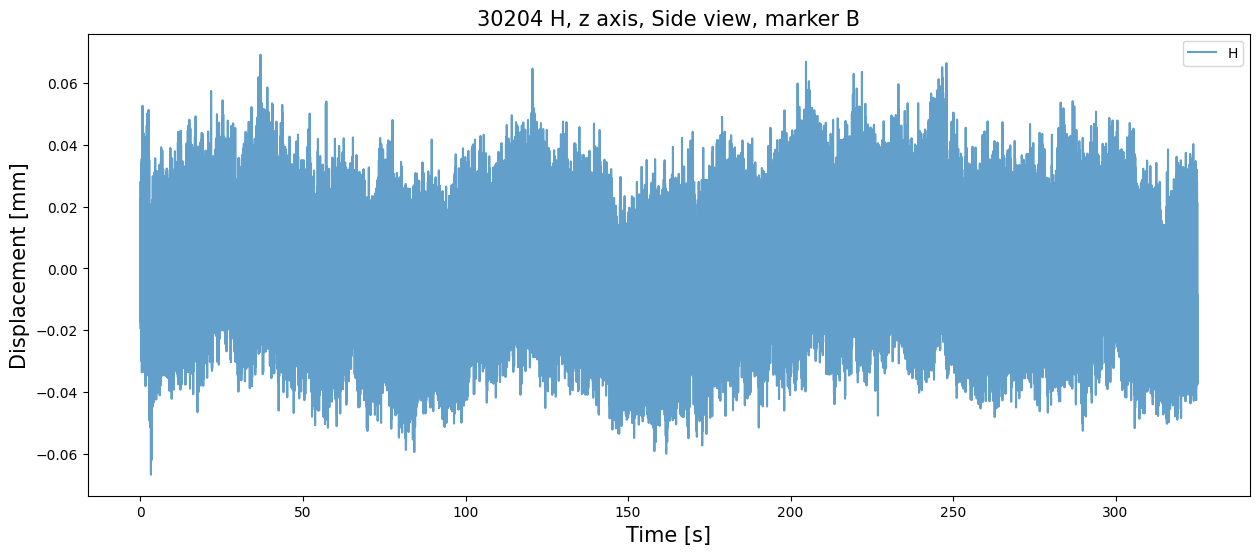

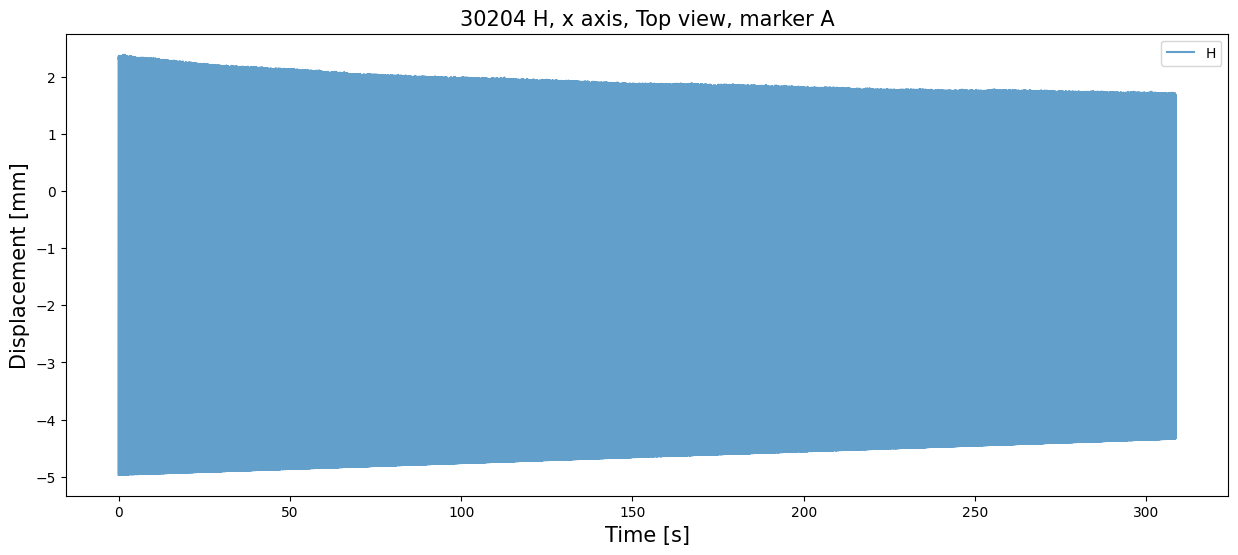

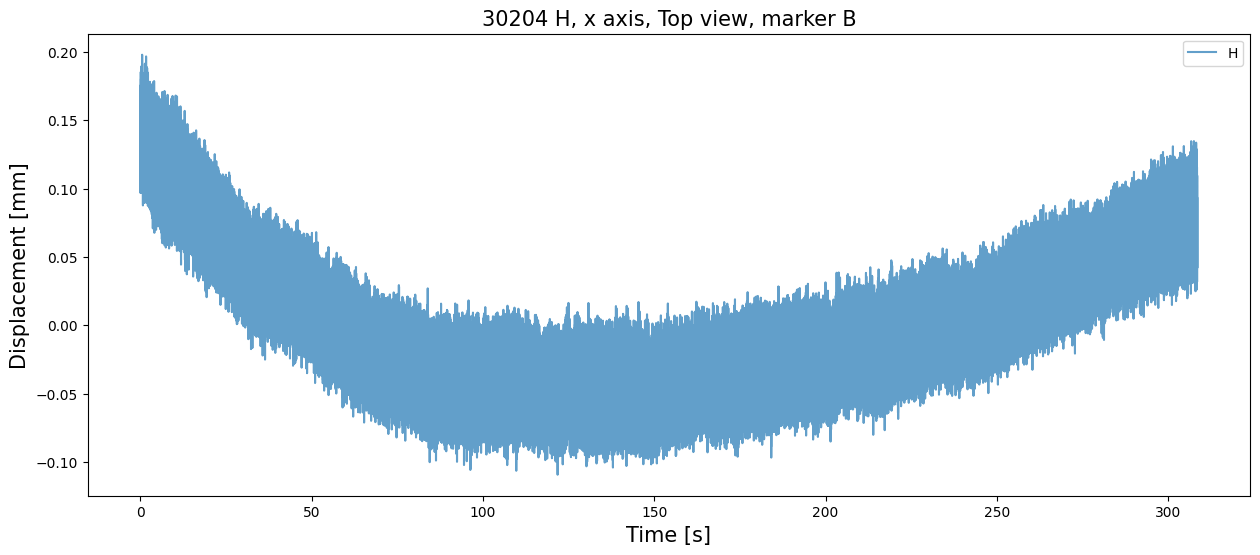

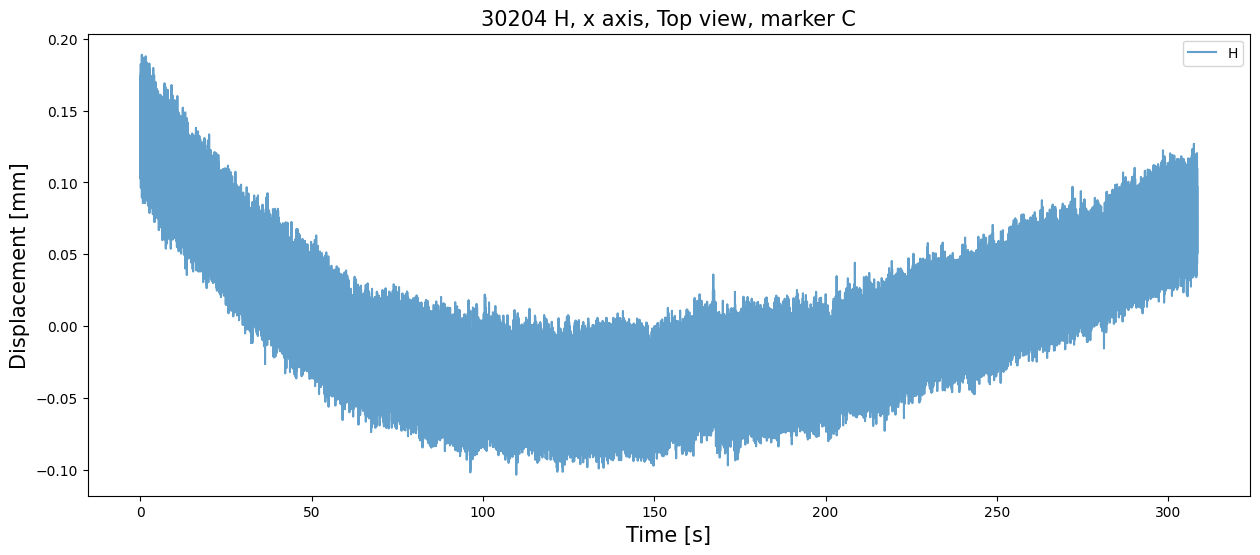

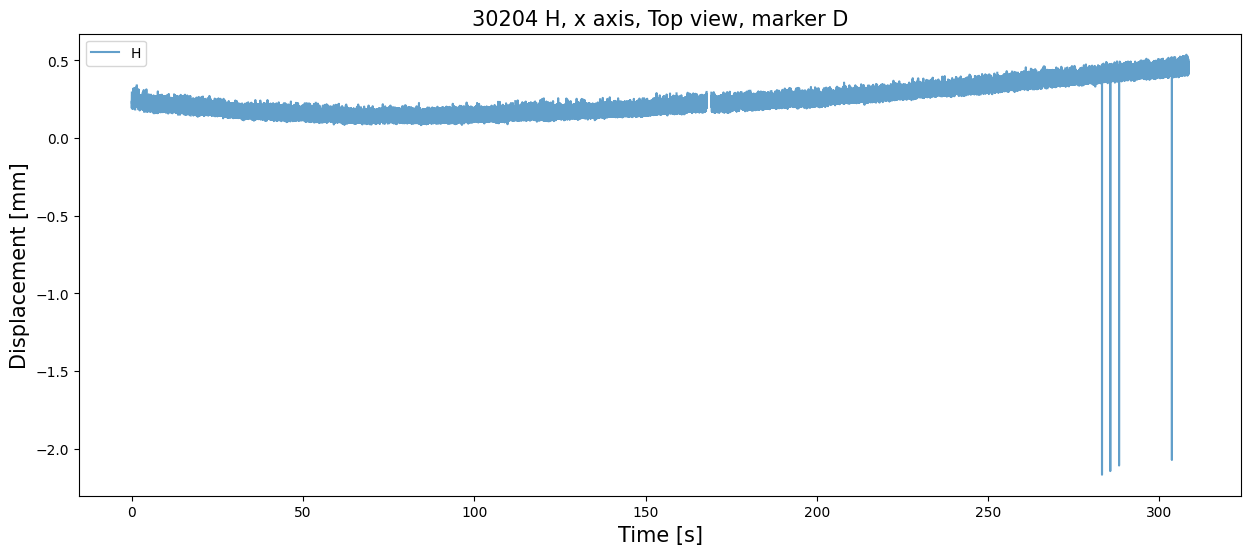

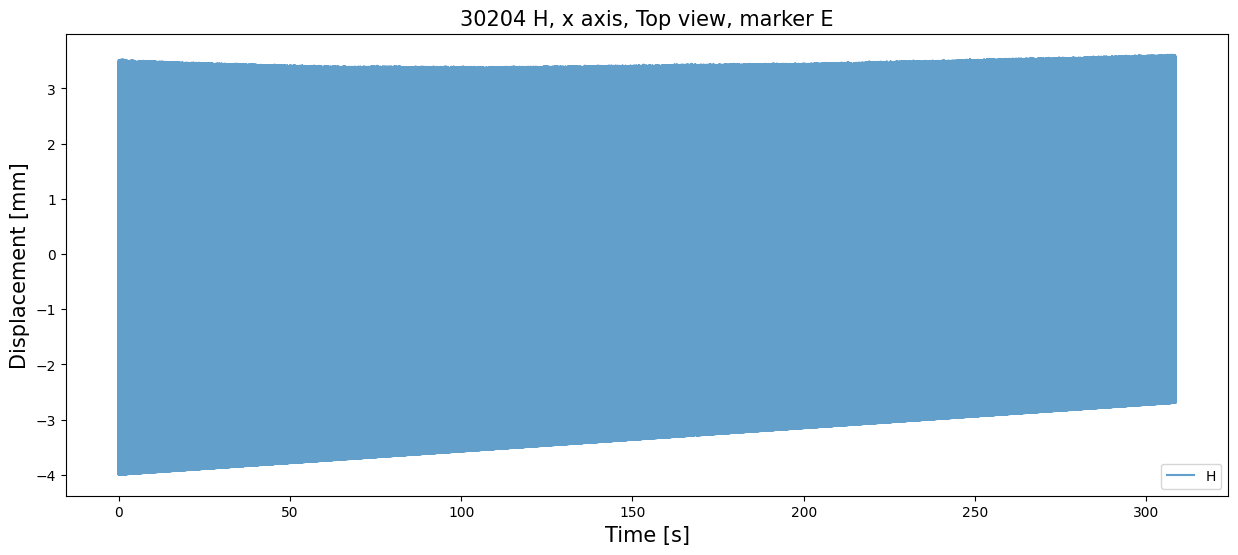

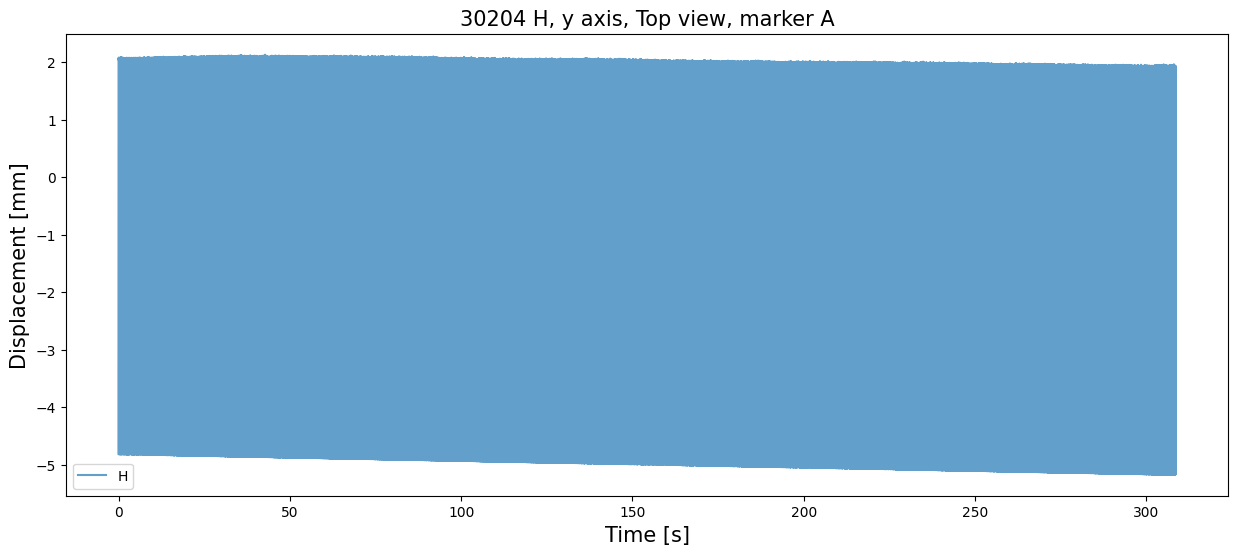

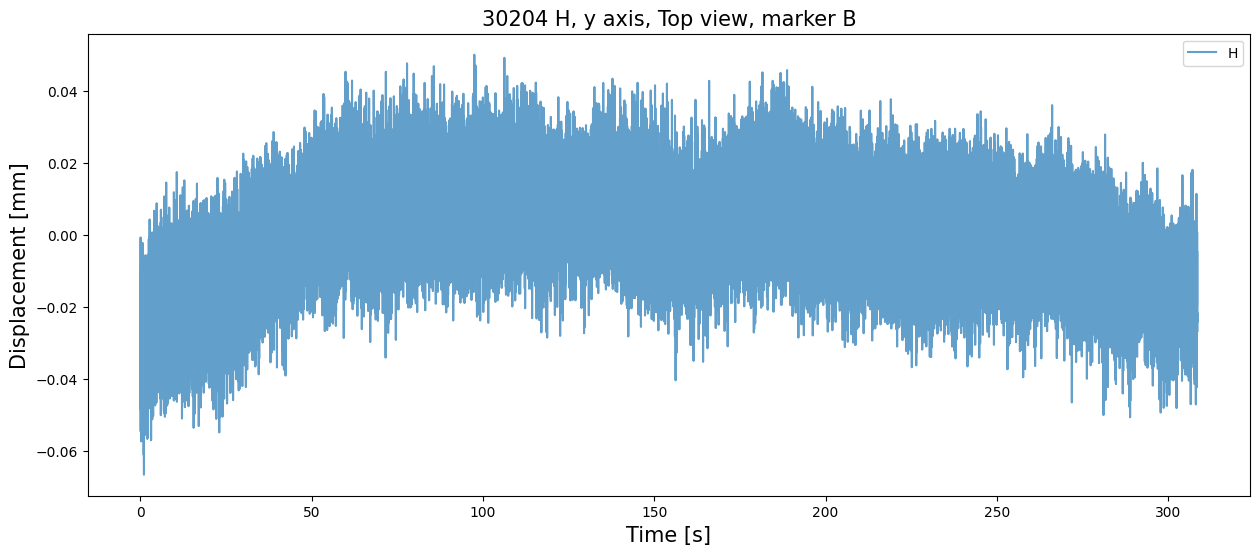

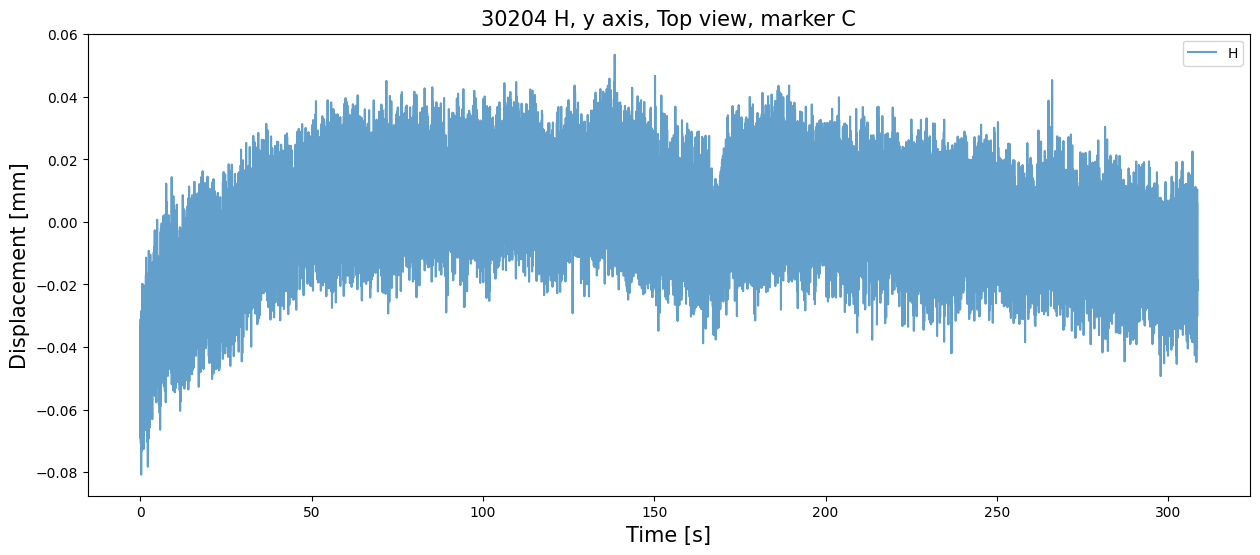

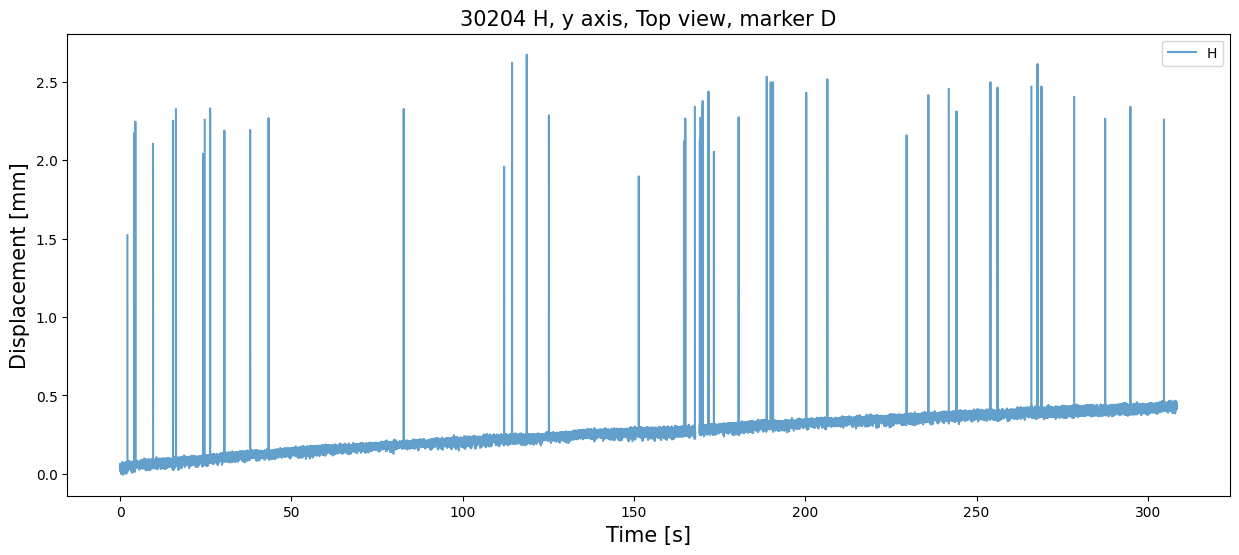

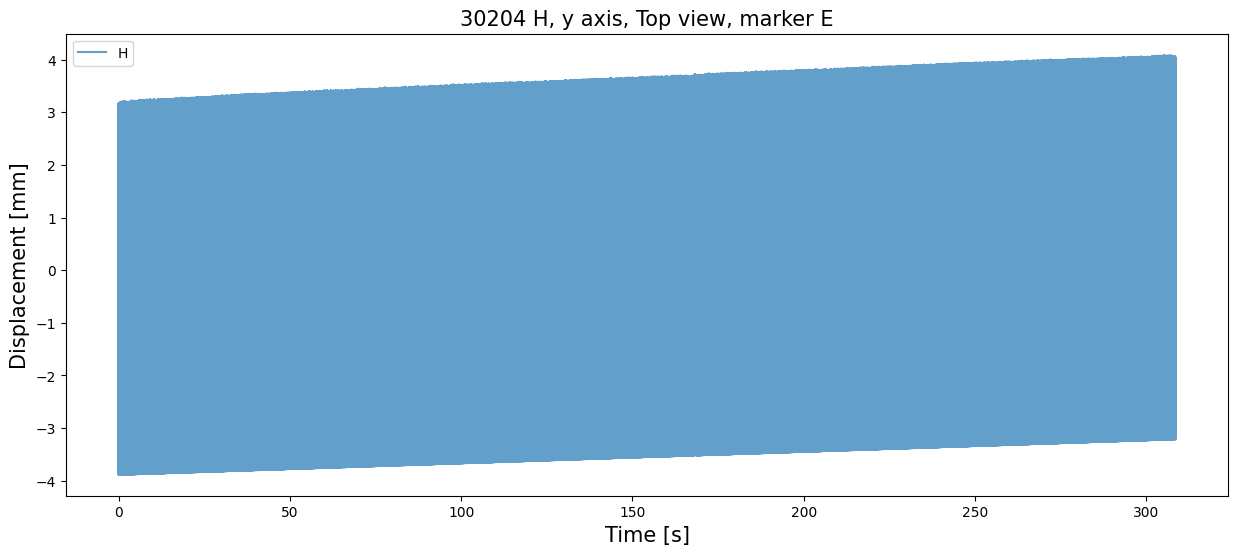

In [156]:
#####################################
# 그래프 보고자 하는 타겟 디렉토리 설정     
target_dir = './0828'
######################################

dir_list = get_dir_list(target_dir)

draw_graphs(dir_list)
